In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
%matplotlib inline

/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 7.1 混合モデル

### コード7.1 三つの正規分布を混合して混合モデルのデータを作る

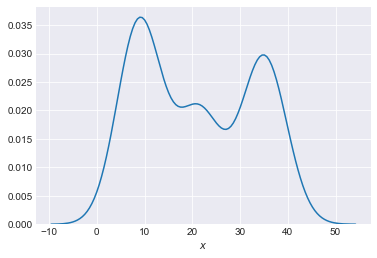

In [2]:
clusters = 3
n_cluster = [90, 50, 75]
n_total = sum(n_cluster)
means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))
sns.kdeplot(np.array(mix))
plt.xlabel('$x$')

### コード7.2 平均と標準偏差が既知の正規分布混合モデルを出力する

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [p]
>CategoricalGibbsMetropolis: [category]
  2%|▏         | 242/10500 [00:09<07:02, 24.28it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10500/10500 [05:58<00:00, 29.30it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125225588>,
      dtype=object)

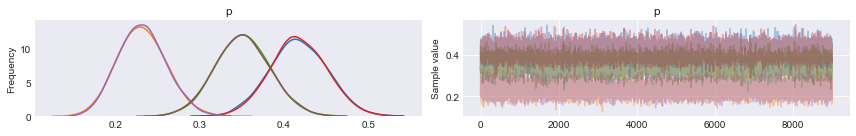

In [3]:
with pm.Model() as model_kg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total)
    
    means = pm.math.constant([10, 20, 35])
    y = pm.Normal('y', mu=means[category], sd=2, observed=mix)
    trace_kg = pm.sample(10000, njobs=1)
    
chain_kg = trace_kg[1000:]
varnames_kg = ['p']
pm.traceplot(chain_kg, varnames_kg)

### コード7.3 三つの平均、一つの共有標準偏差の正規分布混合モデルを出力する

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sd, means, p]
>CategoricalGibbsMetropolis: [category]
  2%|▏         | 203/10500 [00:09<08:23, 20.46it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10500/10500 [07:15<00:00, 24.11it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127863390>,
      dtype=object)

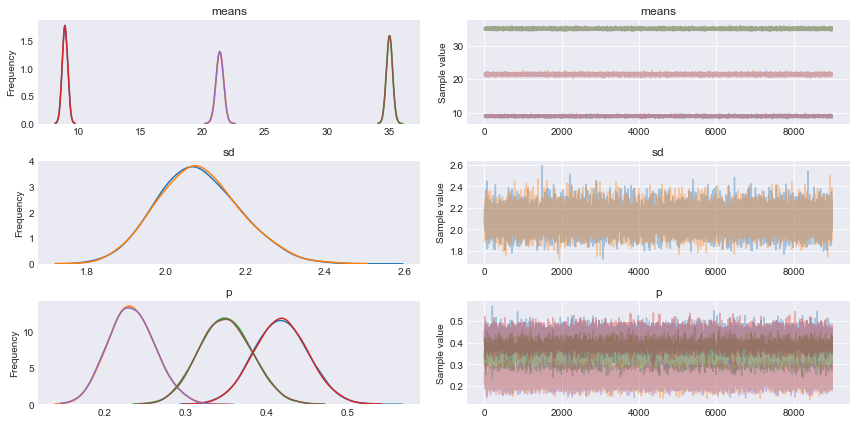

In [5]:
with pm.Model() as model_ug:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total)
    
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)
    trace_ug = pm.sample(10000, njobs=1)
    
chain_ug = trace_ug[1000:]
varnames_ug = ['means', 'sd', 'p']
pm.traceplot(chain_ug, varnames_ug)

In [7]:
pm.summary(chain_ug,varnames_ug)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,8.935603,0.219566,0.001246,8.523300,9.376916,26025.869602,0.999984
means__1,21.377660,0.294360,0.002219,20.817303,21.974157,18777.879429,1.000018
means__2,35.027077,0.243905,0.001403,34.552265,35.508807,22945.253651,1.000007
sd,2.082733,0.103946,0.000824,1.885038,2.289287,15594.352562,0.999988
p__0,0.417568,0.033093,0.000163,0.353608,0.483341,33501.494284,0.999949
p__1,0.233272,0.028613,0.000178,0.177556,0.289255,23450.445668,0.999963
p__2,0.349160,0.032353,0.000195,0.287186,0.412851,26219.716425,0.999947


### コード7.6 混合モデルを出力する

100%|██████████| 50/50 [00:00<00:00, 579.00it/s]


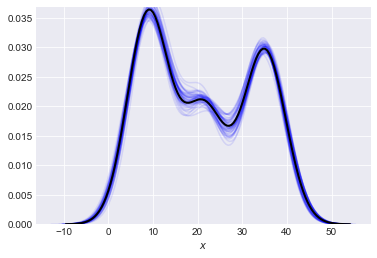

In [9]:
ppc = pm.sample_ppc(chain_ug, 50, model_ug)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
    
sns.kdeplot(np.array(mix), lw=2, color='k')
plt.xlabel('$x$')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
 35%|███▌      | 3676/10500 [00:09<00:18, 370.78it/s]/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 10500/10500 [00:20<00:00, 518.65it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130924240>,
      dtype=object)

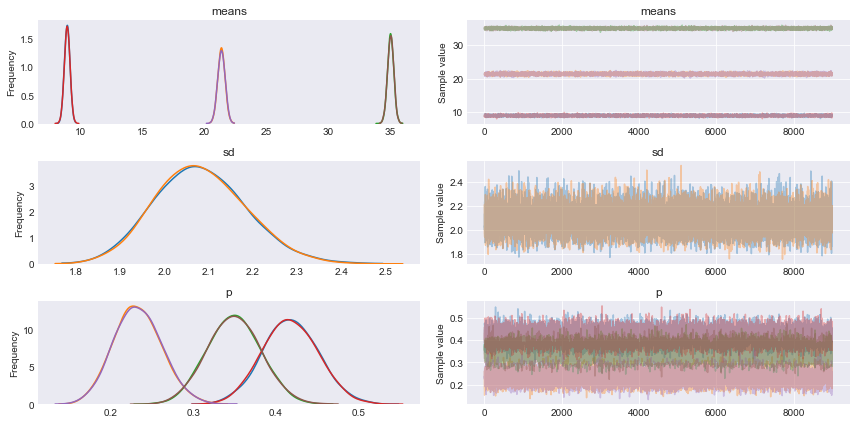

In [14]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    #category = pm.Categorical('category', p=p, shape=n_total)
    
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)
    trace_mg = pm.sample(10000, njobs=1)
    
chain_mg = trace_mg[1000:]
varnames_mg = ['means', 'sd', 'p']
pm.traceplot(chain_mg, varnames_mg)

In [15]:
pm.summary(chain_mg,varnames_mg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,8.932874,0.220678,0.001595,8.499119,9.362739,20117.938216,0.999981
means__1,21.377681,0.294706,0.001657,20.806684,21.960207,31726.851079,0.999951
means__2,35.029805,0.245279,0.001586,34.559223,35.525129,22519.170792,0.999944
sd,2.082253,0.102551,0.000618,1.880200,2.279426,27323.448037,0.999948
p__0,0.417768,0.033415,0.000200,0.353064,0.483473,26928.765767,1.000071
p__1,0.232908,0.028942,0.000165,0.177154,0.290499,27742.751587,0.999993
p__2,0.349324,0.032013,0.000203,0.288216,0.412153,27461.150430,0.999974


100%|██████████| 50/50 [00:00<00:00, 255.32it/s]


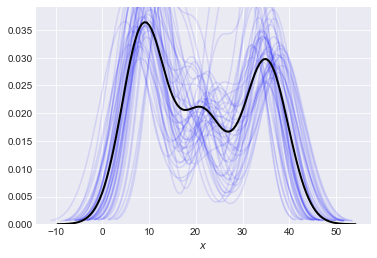

In [16]:
ppc = pm.sample_ppc(chain_mg, 50, model_mg)
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='b')
    
sns.kdeplot(np.array(mix), lw=2, color='k')
plt.xlabel('$x$')

###  コード7.8 $\lambda$が異なる４種類のポアソン分布を表示する

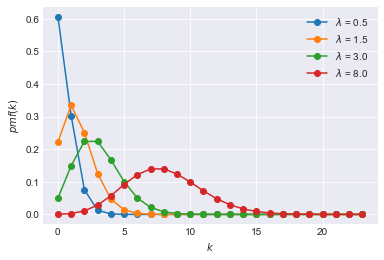

In [17]:
lam_params = [0.5, 1.5, 3, 8]
k = np.arange(0, max(lam_params) * 3)
for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label="$\\lambda$ = {:3.1f}".format(lam))
plt.legend()
plt.xlabel('$k$')
plt.ylabel('$pmf(k)$')

### コード7.9 ZIPモデルのKDEとトレースを出力する

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, psi]
100%|██████████| 5500/5500 [00:05<00:00, 975.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a764748>,
      dtype=object)

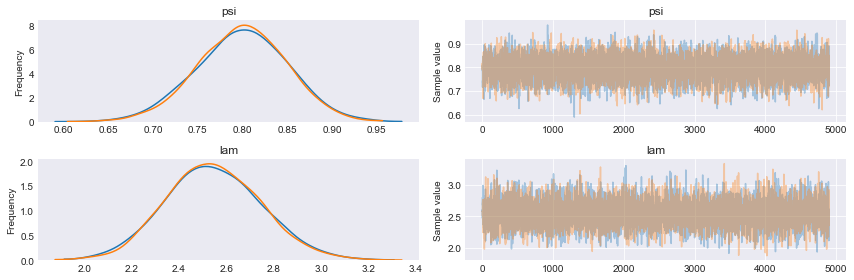

In [18]:
np.random.seed(42)
n = 100
theta = 2.5
pi = 0.1

counts = np.array([(np.random.random() > pi) * np.random.poisson(theta) for i in range(n)])

with pm.Model() as ZIP:
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Gamma('lam', 2, 0.1)
    
    y = pm.ZeroInflatedPoisson('y', psi, lam, observed=counts)
    trace_ZIP = pm.sample(5000, njobs=1)
    
chain_ZIP = trace_ZIP[100:]
pm.traceplot(chain_ZIP)

### コード7.10 ZIP回帰モデルのKDEとトレースを出力する

In [19]:
fish_data = pd.read_csv('https://stats.idre.ucla.edu/stat/data/fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [22]:
fish_data.describe()

,nofish,livebait,camper,persons,child,xb,zg,count
count,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,250.000000,250.000000
mean,0.296000,0.864000,0.588000,2.52800,0.684000,0.973796,0.252323,3.296000
std,0.457407,0.343476,0.493182,1.11273,0.850315,1.440277,2.102391,11.635028
min,0.000000,0.000000,0.000000,1.00000,0.000000,-3.275050,-5.625944,0.000000
25%,0.000000,1.000000,0.000000,2.00000,0.000000,0.008267,-1.252724,0.000000
50%,0.000000,1.000000,1.000000,2.00000,0.000000,0.954550,0.605079,0.000000
75%,1.000000,1.000000,1.000000,4.00000,1.000000,1.963855,1.993237,2.000000
max,1.000000,1.000000,1.000000,4.00000,3.000000,5.352674,4.263185,149.000000


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha, psi]
100%|██████████| 2500/2500 [00:07<00:00, 341.16it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b032c88>,
      dtype=object)

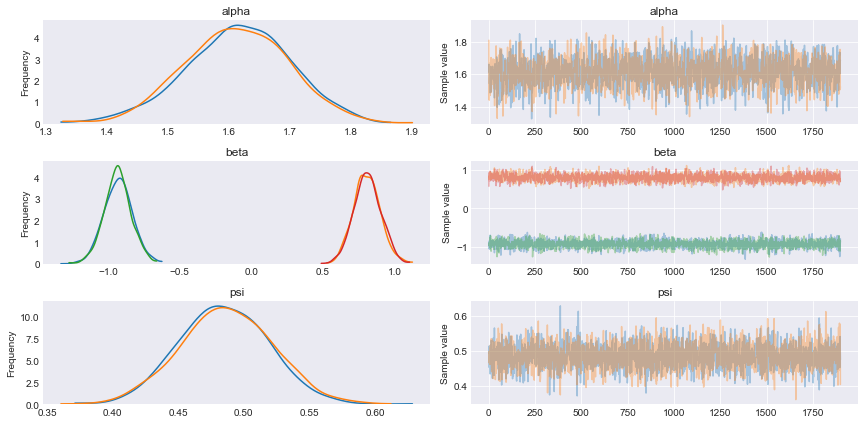

In [20]:
# childとcamperの変数からcountを予測するモデルを構築する
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    lam = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    
    y = pm.ZeroInflatedPoisson('y', psi, lam, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(2000, njobs=1)
    
chain_ZIP_reg = trace_ZIP_reg[100:]
pm.traceplot(chain_ZIP_reg)

In [21]:
pm.summary(chain_ZIP_reg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.613342,0.085123,0.001854,1.451917,1.784419,1885.573067,1.000241
beta__0,-0.932841,0.096579,0.001837,-1.127189,-0.743296,3073.056428,1.000371
beta__1,0.806472,0.093225,0.001926,0.631537,0.994507,1936.581039,1.000117
psi,0.485386,0.034290,0.000713,0.417868,0.549643,2648.543965,1.000865


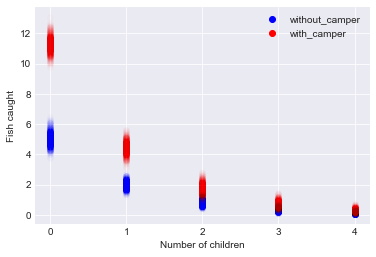

In [23]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
for n in children:
    without_camper = chain_ZIP_reg['alpha'][::thin] + chain_ZIP_reg['beta'][:, 0][::thin] * n
    with_camper = without_camper + chain_ZIP_reg['beta'][:, 1][::thin] * 1
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
plt.plot(children, fish_count_pred_0, 'bo', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'ro', alpha=0.01)

plt.xticks(children)
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'bo', label='without_camper')
plt.plot([], 'ro', label='with_camper')
plt.legend()

### コード7.13 アイリスデータセット＋人工的追加データを表示する

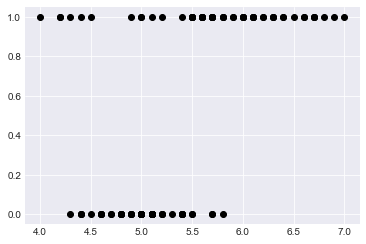

In [25]:
iris = sns.load_dataset('iris')
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()

plt.plot(x_0, y_0, 'o', color='k')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pi, beta, alpha_tmp]
100%|██████████| 2500/2500 [00:03<00:00, 638.34it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x132264f60>,
      dtype=object)

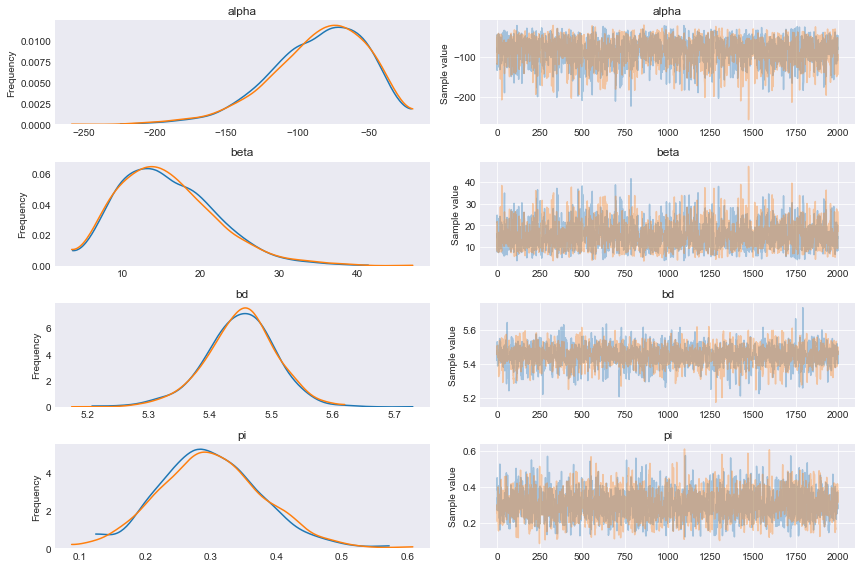

In [26]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta', 1/ (1 + pm.math.exp(-mu)))
    
    pi = pm.Beta('pi', 1, 1)
    p = pi * 0.5 + (1 - pi) * theta
    
    alpha = pm.Deterministic('alpha', alpha_tmp -beta * x_0.mean())
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    trace_rlg = pm.sample(2000, njobs=1)
    
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.traceplot(trace_rlg, varnames)

In [28]:
pm.summary(trace_rlg, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-85.663363,33.639693,0.827576,-150.126822,-27.248485,1669.095716,0.999824
beta,15.715400,6.155881,0.150740,5.051962,27.541295,1687.518832,0.999834
bd,5.448532,0.057034,0.001250,5.331144,5.559423,2111.203962,1.000040
pi,0.300044,0.077372,0.001496,0.147615,0.450908,2477.157480,0.999836


### コード7.16 頑健ロジスティック回帰モデルのHPDを出力する

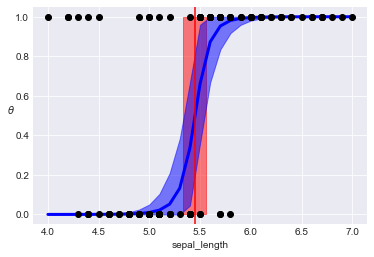

In [29]:
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3)
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:, 1], color='b', alpha=0.5)

plt.xlabel(x_n)
plt.ylabel('$\\theta$', rotation=0)